Load the Kaggle dataset

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Install the Ultralytics

In [2]:
!pip install ultralytics

Load the dataset in the variable as path and image size

In [ ]:
man_data_path = r"/kaggle/input/mango-leaf-disease-dataset"
cas_data_path = r"/kaggle/input/cassava-leaf-disease-classification/data"
rice_data_path = r"/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG"
sugar_data_path = r'/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs'
pot_data_path = r'/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training'
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 25

file path and file name for disease label for each image

In [ ]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df


In [ ]:
mango_df = df_maker(man_data_path)
mango_df

In [ ]:
cassava_df = df_maker(cas_data_path)
cassava_df

In [ ]:
rice_df = df_maker(rice_data_path)
rice_df

In [ ]:
sugar_df = df_maker(sugar_data_path)
sugar_df

In [ ]:
potato_df = df_maker(pot_data_path)
potato_df

Combine all the 5 disease dataset as single dataset

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Rename 'Healthy' labels to unique names
mango_df["labels"] = mango_df["labels"].replace("Healthy", "healthy_mango_leaf")
sugar_df["labels"] = sugar_df["labels"].replace("Healthy", "healthy_sugarcane_leaf")
potato_df["labels"] = potato_df["labels"].replace("Healthy", "healthy_potato_leaf")

# Combine all datasets into one
full_dataset = pd.concat([mango_df, sugar_df, potato_df, rice_df, cassava_df], ignore_index=True)
print("labels :",full_dataset.labels.value_counts())



# Display dataset info
print(f"Total Images: {len(full_dataset)}")
print(full_dataset.head())

# Function to display one sample image from each dataset
def show_sample_images(df, title):
    sample = df.sample(1).iloc[0]
    img = cv2.imread(sample["file_paths"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(f"{title}: {sample['labels']}")
    plt.axis("off")

# Show one sample from each dataset
plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
show_sample_images(mango_df, "Mango")

plt.subplot(2, 3, 2)
show_sample_images(sugar_df, "Sugarcane")

plt.subplot(2, 3, 3)
show_sample_images(potato_df, "Potato")

plt.subplot(2, 3, 4)
show_sample_images(rice_df, "Rice")

plt.subplot(2, 3, 5)
show_sample_images(cassava_df, "Cassava")

plt.tight_layout()
plt.show()


Load the YOLOv8 model and preprocessing code

In [ ]:
import os
import cv2
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# Define final dataset folder
OUTPUT_DIR = "/kaggle/working/YOLOv8_Dataset"

# Create output directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(OUTPUT_DIR, split)
    os.makedirs(split_path, exist_ok=True)


# Train-Test Split (80% Train, 10% Val, 10% Test)
train_df, temp_df = train_test_split(full_dataset, test_size=0.2, random_state=42, stratify=full_dataset['labels'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# Function to process and save images
def process_and_save(df, split):
    for _, row in df.iterrows():
        img_path = row["file_paths"]
        label = row["labels"]

        # Define class folder
        class_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(class_dir, exist_ok=True)

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (448, 448))  # Match training size
        img = img / 255.0  # Normalize (0-1)

        # Save image
        new_img_path = os.path.join(class_dir, os.path.basename(img_path))
        cv2.imwrite(new_img_path, img * 255)  # Convert back to 0-255 before saving

# Process train, val, and test sets
process_and_save(train_df, "train")
process_and_save(val_df, "val")
process_and_save(test_df, "test")

# Save class names for YOLO training
class_names = sorted(full_dataset["labels"].unique())
with open(os.path.join(OUTPUT_DIR, "classes.txt"), "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print("✅ Dataset ready for YOLOv8 training!")


Train and Test the model and,
Save the model

In [ ]:
from ultralytics import YOLO

# Define paths
DATASET_PATH = "/kaggle/working/YOLOv8_Dataset"

# Load YOLOv8 model (use 'n' for nano, or 's' for small)
model = YOLO("yolov8s.pt")  # Classification model    model = YOLO("yolov8s-cls.pt") for the classiciation only     

# Train the model with optimizations
model.train(
    data=DATASET_PATH,  
    epochs=15,  # Reduce epochs for faster training
    imgsz=448,  # Reduce image size (640 → 448) for speed
    batch=32,  # Increase batch size (reduce iterations)
    patience=3,  # Early stopping if no improvement
    optimizer="AdamW",  # Faster optimizer
    lr0=0.002,  # Slightly higher learning rate
    dropout=0.05,  # Reduce dropout to speed up training
    workers=2,  # Use fewer workers to reduce CPU load
    device="cuda"  # Ensure GPU is used
)



# Save trained model
model_path = "/kaggle/working/yolov8_plant_disease.pt"
model.save(model_path)

print(f"✅ Model training complete! Saved at {model_path}")


Login the huggingface 

In [ ]:
from huggingface_hub import login,HfFolder

# Log in to Hugging Face Hub
# Replace "YOUR_TOKEN" with your actual Hugging Face token
login(token="Use your hub tokens")

Upload the trained model

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Define your repo name (change 'your-username' to your actual HF username)
repo_name = "Lucario-K17/YOLOv8-5_Plant-Diseases"



# Specify files to upload (Only the model, exclude dataset)
files_to_upload = [
    "/kaggle/working/yolov8_plant_disease.pt"  # Model file
]

# Initialize HF API
api = HfApi()

# Push selected files to Hugging Face
for file in files_to_upload:
    api.upload_file(
        path_or_fileobj=file,
        path_in_repo=file.split("/")[-1],  # Upload with same filename
        repo_id=repo_name,
        repo_type="model"
    )

print(f"✅ Model pushed successfully to: https://huggingface.co/{repo_name}")


Load the model from the huggingface and test it.

In [ ]:
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define your Hugging Face model repo
repo_name = "Lucario-K17/YOLOv8-5_Plant-Diseases"

# Download model from Hugging Face
model_path = hf_hub_download(repo_id=repo_name, filename="yolov8_plant_disease.pt", repo_type="model")

# Load YOLOv8 model
model = YOLO(model_path)

# Load a test image (update path)
test_image_path = mango_df['file_paths'].iloc[0]  # Update with actual path

# Read and preprocess image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
img_resized = cv2.resize(img, (448, 448))  # Resize to match training size

# Run inference
results = model(img_resized)  # This returns a list

# Extract the first result object from the list
result = results[0]

# Get predicted class index
predicted_class = result.probs.top1  # Get top predicted class index

# Get class names
class_names = model.names  # YOLO stores class names here

# Show image with title
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.show()

print(f"✅ Predicted Class: {class_names[predicted_class]}")


Disease related information for this

In [ ]:
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define Hugging Face model repo
repo_name = "Lucario-K17/YOLOv8-5_Plant-Diseases"

# Download model from Hugging Face
model_path = hf_hub_download(repo_id=repo_name, filename="yolov8_plant_disease.pt", repo_type="model")

# Load YOLOv8 model
model = YOLO(model_path)

# Select a test image (example from Mango dataset)
test_image_path = mango_df['file_paths'].iloc[0]  # Change dataset if needed

# Load and preprocess image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

# Run YOLO detection
results = model(img)
result = results[0]

# Check if detections exist
if result.boxes is not None and len(result.boxes) > 0:
    # Draw bounding boxes
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        confidence = box.conf[0].item()  # Confidence score
        class_id = int(box.cls[0].item())  # Class ID
        class_name = model.names[class_id]  # Class name

        # Draw rectangle and label
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Blue box
        cv2.putText(img, f"{class_name} ({confidence:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Detected Plant Disease")
    plt.show()

else:
    print("❌ No disease detected in the image!")

# ----------- Disease Severity Estimation (Area Ratio Calculation) -----------

def calculate_severity(image_path, mask_threshold=100):
    """
    Estimates disease severity by calculating the infected area ratio.

    :param image_path: Path to test image
    :param mask_threshold: Threshold for detecting disease area
    :return: Disease severity percentage and classification
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply thresholding to segment diseased regions
    _, disease_mask = cv2.threshold(gray, mask_threshold, 255, cv2.THRESH_BINARY_INV)

    # Calculate areas
    total_area = img.shape[0] * img.shape[1]  # Total pixels
    infected_area = np.sum(disease_mask == 255)  # Count white pixels

    # Compute severity percentage
    severity_percentage = (infected_area / total_area) * 100

    # Categorize severity level
    if severity_percentage < 20:
        severity_label = "Mild"
    elif 20 <= severity_percentage < 50:
        severity_label = "Moderate"
    else:
        severity_label = "Severe"

    return severity_percentage, severity_label

# Test severity calculation
severity_percentage, severity_label = calculate_severity(test_image_path)

print(f"🌱 Disease Severity: {severity_percentage:.2f}% ({severity_label})")


Segmentation for the diseases.


0: 448x448 BacterialBlights 1.00, Cassava___brown_streak_disease 0.00, Cassava___green_mottle 0.00, RedRot 0.00, Cassava___healthy 0.00, 3.4ms
Speed: 16.0ms preprocess, 3.4ms inference, 0.1ms postprocess per image at shape (1, 3, 448, 448)
🩺 Predicted Disease: BacterialBlights


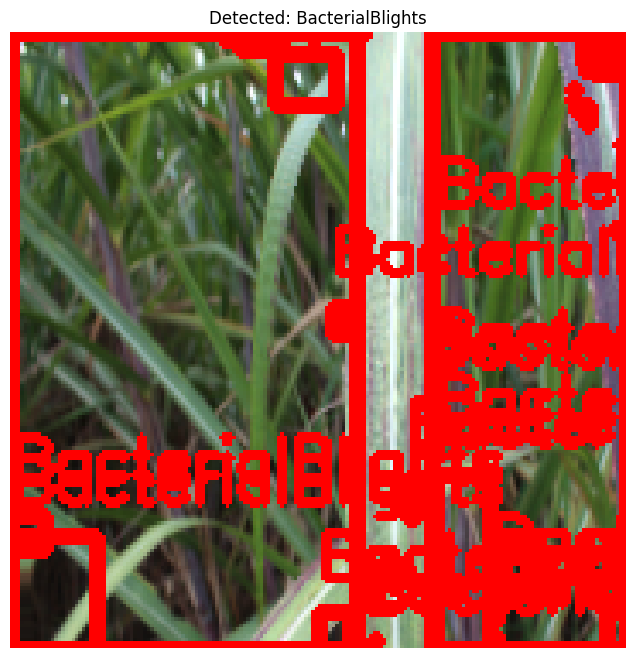

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

# Load classification model (it does NOT predict bounding boxes)
repo_name = "Lucario-K17/YOLOv8-5_Plant-Diseases"
model_path = hf_hub_download(repo_id=repo_name, filename="yolov8_plant_disease.pt", repo_type="model")
model = YOLO(model_path)

# Load a test image
test_image_path = '/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs/BacterialBlights/cropped_Bacterial Blight_2647.png' # Example image
img = cv2.imread(test_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run YOLO classification
results = model(img_rgb)
predicted_class = results[0].probs.top1  # Get highest probability class index
predicted_label = model.names[predicted_class]  # Get class name

print(f"🩺 Predicted Disease: {predicted_label}")

# --------- Disease Area Segmentation (Find Bounding Box) ---------

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply threshold to detect infected regions
_, mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold as needed

# Find contours (disease areas)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Draw blue bounding box
    cv2.putText(img_rgb, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Display Image
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Detected: {predicted_label}")
plt.show()


In [20]:
import pandas as pd
info = pd.read_csv("/kaggle/input/plant-disease-prevent/Plant_disease_prevent.csv")
info.head()

,disease,text
0,Anthracnose,About the Disease\nAnthracnose is a fungal dis...
1,Bacterial Canker,About the Disease\nBacterial canker is caused ...
2,Bacterial Leaf Blight,About the Disease\nBacterial leaf blight is ca...
3,BacterialBlights,"About the Disease\nBacterial blight, caused by..."
4,Brown Spot,About the Disease\nBrown Spot is a fungal dise...


In [22]:
import pandas as pd

# Check for 'Yellow' in disease column
def get_disease_info():
    result = info[info['disease'].str.contains(predicted_label, case=False, na=False)]
    if not result.empty:
        return result['text'].values[0]  # Return the text for the first match
    else:
        return "No information available"

# Example usage
print(get_disease_info())


About the Disease
Bacterial blight, caused by Xanthomonas campestris, causes angular water-soaked lesions on leaves and stems, leading to premature defoliation.

Causes
High humidity and warm temperatures
Overcrowding of plants
Wounds from insects or mechanical damage
Prevention & Control
✅ Cultural Methods:

Ensure proper orchard sanitation by removing infected parts.
Use resistant mango varieties if available.
✅ Chemical Control:

Spray Streptocycline (500 ppm) + Copper Oxychloride (3g/L water) every 15 days.
Use Bordeaux mixture (1%) to prevent infection.
✅ Organic/Natural Control:

Apply Trichoderma viride to soil and foliar spray.
Use neem-based formulations to reduce bacterial spread.
✅ How to Increase Yield

Apply FYM (20-25 kg/tree) and Micronutrients (Zn, Fe, Mg).
Use Potassium Nitrate (2%) foliar spray for better fruit quality.


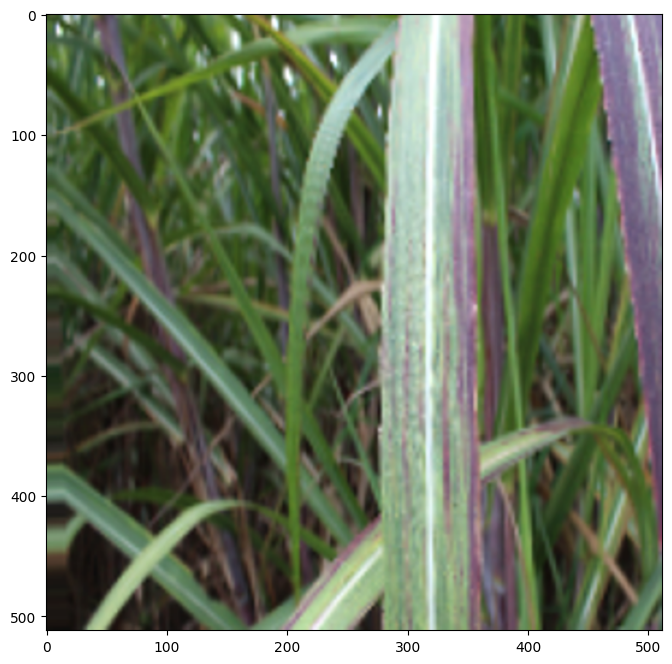

In [25]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the EfficientDet model from TensorFlow Hub
efficientdet_model_url = "https://tfhub.dev/tensorflow/efficientdet/d0/1"  # You can change 'd0' to 'd1', 'd2', etc.

detector = hub.load(efficientdet_model_url)

# Function to perform inference
def detect_objects(image_tensor):
    """
    Runs object detection on the input image tensor.
    Args:
        image_tensor: A 4D tensor of shape [1, height, width, 3], dtype=tf.uint8
    Returns:
        A dictionary with detection results.
    """
    return detector(image_tensor)

# Function to visualize results
def visualize_detections(image, results, threshold=0.3):
    """
    Displays image with bounding boxes for detected objects.
    Args:
        image: Original PIL image.
        results: Detection results from the model.
        threshold: Minimum confidence score for displaying a bounding box.
    """
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    height, width = image.size[1], image.size[0]
    
    for i in range(len(results['detection_scores'][0])):
        score = results['detection_scores'][0][i].numpy()
        if score < threshold:
            continue
        
        bbox = results['detection_boxes'][0][i].numpy()
        ymin, xmin, ymax, xmax = bbox
        xmin, xmax, ymin, ymax = xmin * width, xmax * width, ymin * height, ymax * height
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        label = f"{results['detection_classes'][0][i].numpy()} ({score:.2f})"
        ax.text(xmin, ymin - 5, label, color='red', fontsize=12, backgroundcolor='black')
    
    plt.show()

# Load an image and preprocess it
image_path =  '/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs/BacterialBlights/cropped_Bacterial Blight_2647.png'  # Replace with your image path
image = Image.open(image_path).resize((512, 512))  # Resize to model input size
image_tensor = tf.convert_to_tensor(np.array(image), dtype=tf.uint8)  # Convert to uint8
image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

# Run detection
results = detect_objects(image_tensor)

# Display results
visualize_detections(image, results)

In [5]:
!pip install huggingface\

import huggingface
from huggingface_hub import login

# Replace 'your_huggingface_token' with your actual access token
login("Use huggingface token and login to gain the access to use the cropinailab/aksara_v1 model")


Load the model(cropinailab/aksara_v1)  for chatbot.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def load_model():
    model_name = "cropinailab/aksara_v1"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
    return model, tokenizer

def ask_question(model, tokenizer, question):
    inputs = tokenizer(question, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=200)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

if __name__ == "__main__":
    model, tokenizer = load_model()
    question = "What is the best fertilizer and measurement for preventing Brown Spot in rice?"
    response = ask_question(model, tokenizer, question)
    print("Response:", response)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]